# Normalization of $T_1$-weighted images
T1-weighted images offer an opportunity to study signal intensity increases due to contrast enhancement, without having to convert the signals to concentrations. However, as differences in for example the magnetic field may significantly impact the signal intensity values of a T1-weighted image, we need to normalize these images first. For this purpose, we want to find some part of the image which is well registered between the sessions, has a relatively high signal to reduce SNR, and where the contrast agent is not expected to enter. The orbital fat behind the eye suits all of these requirements well. Then we want to label this reference-region, and finally scale the images relative to the reference region median value.

This is often done manually, but as always, we want to automate this step for improved reproducibility, and to lower the chances of introducing a bias due to the potential of errors in manual procedures.


## CLI-Usage
These are the commands that are executed to first generate a reference ROI within the orbital fat, and then to normalize a T1-weighted image (here the first session) accordingly. Below are further technical details on how it works.

In [1]:
%%bash
gmri2fem seg orbital-refroi --help;

gmri2fem seg orbital-refroi \
    --T1w_dir "../mri_processed_data/sub-01/registered/" \
    --segmentation "../mri_processed_data/freesurfer/sub-01/mri/aparc+aseg.mgz" \
    --output "../mri_processed_data/sub-01/segmentations/sub-01_seg-refroi-left-orbital_binary.nii.gz" \
    --side "left"

Usage: gmri2fem seg orbital-refroi [OPTIONS]

Options:
  --T1w_dir PATH       [required]
  --segmentation PATH  [required]
  --output PATH        [required]
  --side TEXT
  --help               Show this message and exit.


In [3]:
%%bash
gmri2fem mri t1w-normalize --help;

gmri2fem mri t1w-normalize \
    --input "../mri_processed_data/sub-01/registered/sub-01_ses-01_T1w_registered.nii.gz" \
    --refroi "../mri_processed_data/sub-01/segmentations/sub-01_seg-refroi-left-orbital_binary.nii.gz" \
    --output "../mri_processed_data/sub-01/T1w_normalized/sub-01_ses-01_T1w_normalized.nii.gz"

Usage: gmri2fem mri t1w-normalize [OPTIONS]

Options:
  --input PATH   [required]
  --refroi PATH  [required]
  --output PATH  [required]
  --help         Show this message and exit.


## Technical Details
To automatically generate the mask, we attempt the following procedure:
1. Identify the index of the center of specific segmented regions expected to be aligned with the coordinate axes relative to the orbital fat.
2. Create a distribution surrounding the index center - which could be considered as a probability distribution for the location of the orbital fat.
3. Multiply the distribution with the pre-contrast T1-weighted signal intensities, and create a region based on some threshold. For the thresholding we use Otsu's algorithm, implemented as part of `scikit-image`.
4. Create a common mask for all session by taking the intersection of all voxels in the region defined by applying step 3 to all sessions.
5. Perform binary erosion on the mask to eliminate small indep-structures.
6. In case the mask defines several islands, keep only the largest.
7. Finally remove any voxels which deviates too much from the current median value, as well as any voxels where the temporal standard deviation is larger than som threshold relative to the median value.

In [2]:
import itertools
from pathlib import Path

import nibabel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import skimage

import scipy
import simple_mri as sm
from scipy.stats import multivariate_normal
from simple_mri import load_mri, SimpleMRI, change_of_coordinates_map, apply_affine

from gmri2fem.segmentation_refinement import resample_segmentation
from gmri2fem.utils import largest_island, apply_affine
from gmri2fem.orbital_refroi import (
    AXES_SEG_LABELS,
    orbital_weights_distribution,
    find_axial_label_centers,
    threshold_weighted_image,
    aggregate_session_masks
)
from gmri2fem.visualization import *

mpl.rcParams.update({"font.size": 14})

mri_dataset = Path("../mri_dataset/")
mri_processed_data = Path("../mri_processed_data/")
subject = "sub-01"
mris = [
    sm.load_mri(mri_processed_data / f"{subject}/registered/{subject}_{ses}_T1w_registered.nii.gz", dtype=np.single)
    for ses in [f"ses-{idx+1:02d}" for idx in range(5)]
]
ref_mri = mris[0]
vol = mris[0].data
seg_mri = sm.load_mri(mri_processed_data / f"freesurfer/{subject}/mri/aparc+aseg.mgz", dtype=np.int16)

ras2ref = np.linalg.inv(ref_mri.affine)
seg2ras = seg_mri.affine

In [3]:
mri_dataset = Path("../mri_dataset/")
mri_processed_data = Path("../mri_processed_data/")
subject = "sub-01"
mris = [
    sm.load_mri(mri_processed_data / f"{subject}/registered/{subject}_{ses}_T1w_registered.nii.gz", dtype=np.single)
    for ses in [f"ses-{idx+1:02d}" for idx in range(5)]
]
ref_mri = mris[0]
vol = mris[0].data
seg_mri = sm.load_mri(mri_processed_data / f"freesurfer/{subject}/mri/aparc+aseg.mgz", dtype=np.int16)

ras2ref = np.linalg.inv(ref_mri.affine)
seg2ras = seg_mri.affine

## Generating approximate location distribution for ROI

Segment labels for each axis:  {'left': [1012, 1027, 18], 'right': [2012, 2027, 54]}


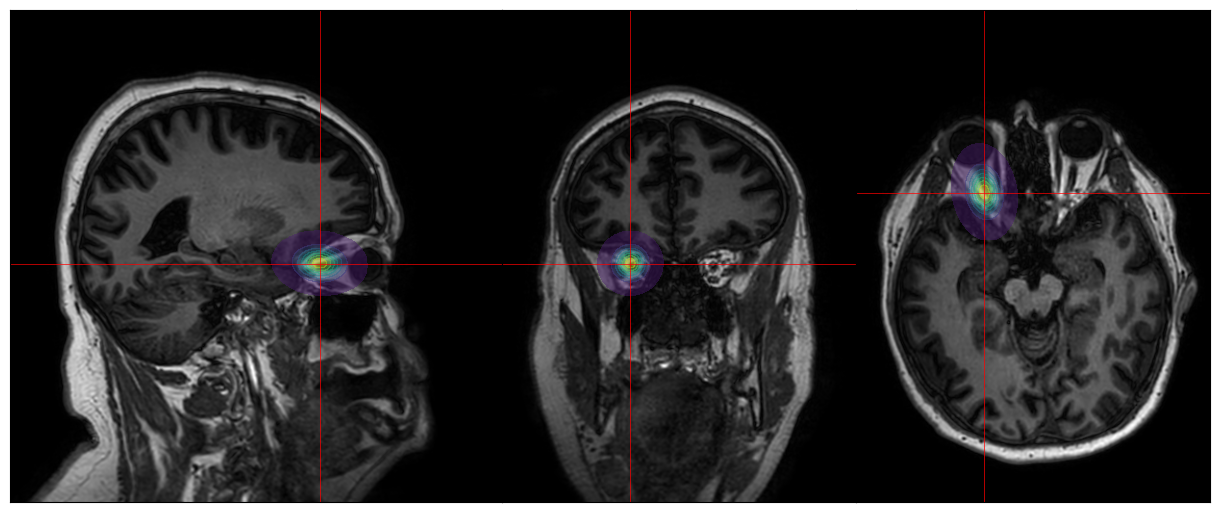

In [4]:
print("Segment labels for each axis: ", AXES_SEG_LABELS)
axes_seg_labels = AXES_SEG_LABELS["left"]
centers_seg = find_axial_label_centers(seg_mri, axes_seg_labels)
centers = np.rint(sm.apply_affine(ras2ref, sm.apply_affine(seg2ras, centers_seg))).astype(int)

weights = orbital_weights_distribution(ref_mri, seg_mri, "left")
vol_distribution = np.where(weights > 1e-6, weights, np.nan)

nR, nA, nS = vol.shape
cR, cA, cS = centers
slices = [
    ("sagittal", centers[0]),
    ("coronal", centers[1]),
    ("axial", centers[2])
]
image_distributions = [
    slice_volume(vol_distribution, *slice_)
    for slice_ in slices
]
T1w_ims = [
    slice_volume(vol, *slice_)
    for slice_ in slices
]


grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.0,
    "fig_left_margin": 0.0,
    "fig_right_margin": 0.0,
    "col_top_margin": 0.0,
    "col_bottom_margin": 0.0,
    "row_left_margin": 0.0,
    "row_right_margin": 0.0,
}
fig, axes = build_image_grid([image_distributions], grid_config)

axes = axes["body"][0]
axes[0].imshow(T1w_ims[0], cmap="gray")
axes[0].contourf(image_distributions[0], alpha=0.45)
axes[0].axhline(nS - cS, c="r", lw=0.5)
axes[0].axvline(cA, c="r", lw=0.5)

axes[1].imshow(T1w_ims[1], cmap="gray")
axes[1].contourf(image_distributions[1], alpha=0.45)
axes[1].axhline(nS - cS, c="r", lw=0.5)
axes[1].axvline(cR, c="r", lw=0.5)

axes[2].imshow(T1w_ims[2], cmap="gray")
axes[2].contourf(image_distributions[2], alpha=0.45)
axes[2].axhline(nA - cA, c="r", lw=0.5)
axes[2].axvline(cR, c="r", lw=0.5)
# plt.savefig("../figures/t1w-normalization-regions.pdf", bbox_inches="tight")
plt.show()

## Threshold product of original image and location distribution

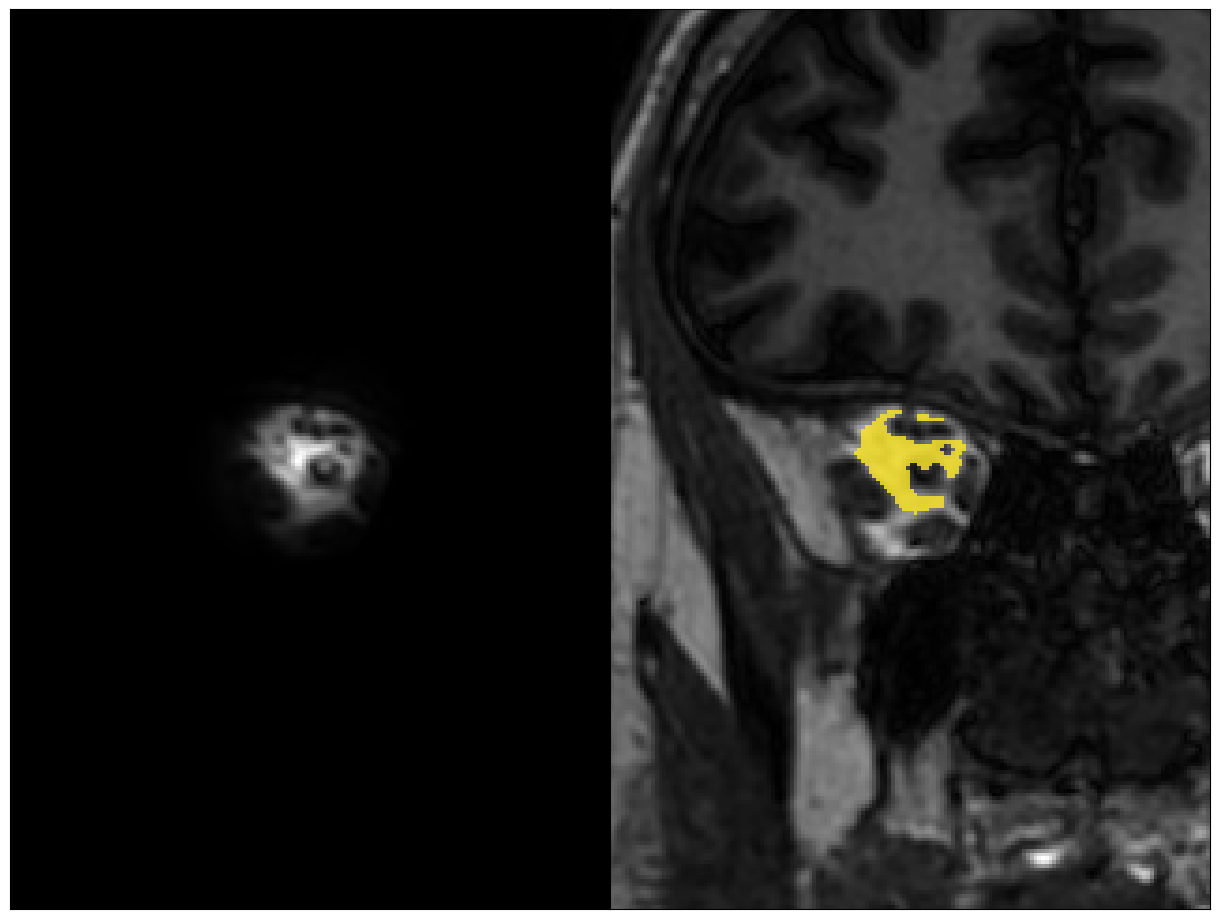

In [20]:
roi_slice = slice_volume(np.where(roi, 1, np.nan), *slices[1])
grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.0,
    "fig_left_margin": 0.0,
    "fig_right_margin": 0.0,
    "col_top_margin": 0.0,
    "col_bottom_margin": 0.0,
    "row_left_margin": 0.0,
    "row_right_margin": 0.0,
}

fig, axes = build_image_grid([[weighted_slice[window], t1w_slice[window]]], grid_config)
axes = axes["body"][0]
axes[0].imshow(weighted_slice[window], cmap="gray", alpha=1)
axes[1].imshow(t1w_slice[window], cmap="gray")
axes[1].imshow(roi_slice[window], cmap="viridis_r", alpha=0.8)
plt.savefig("../figures/t1w-normalization-orbital-masking.pdf")
plt.show()

## Aggregate masks from different sessions

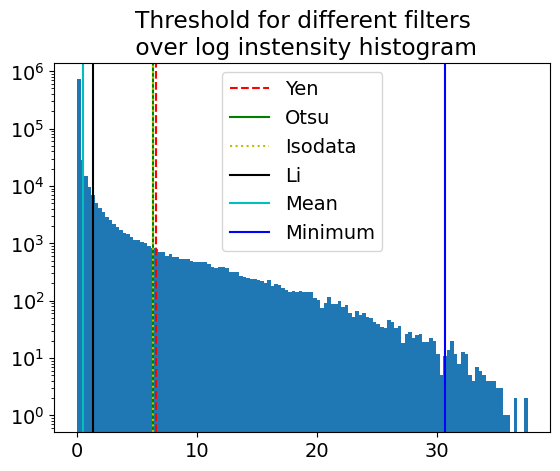

In [6]:
hist, bin_edges, _ = plt.hist(image[image > 1e-6], bins=128)
bins = (bin_edges[:-1] + bin_edges[1:]) / 2
yen_thresh = skimage.filters.threshold_yen(hist=(hist, bins))
otsu_thresh = skimage.filters.threshold_otsu(hist=(hist, bins))
iso_thresh = skimage.filters.threshold_isodata(hist=(hist, bins))
min_thresh = skimage.filters.threshold_minimum(hist=(hist, bins))
li_thresh = skimage.filters.threshold_li(image[image > 1e-6])
mean_thresh = skimage.filters.threshold_mean(image[image > 1e-6])

plt.axvline(yen_thresh, c="r", ls="--",label="Yen")
plt.axvline(otsu_thresh, c="g", label="Otsu")
plt.axvline(iso_thresh, c="y", label="Isodata", ls=":")
plt.axvline(li_thresh, c="k", label="Li")
plt.axvline(mean_thresh, c="c", label="Mean")
plt.axvline(min_thresh, c="b", label="Minimum")

plt.yscale("log")
plt.title("Threshold for different filters\n over log instensity histogram")
plt.legend()
plt.show()

In [16]:
sliced_centers = {
    "sagittal": (nS - cS, cA),
    "coronal": (nS - cS, cR),
    "axial": (nA - cA, cS)
}
orientation = "coronal"
width = 80
height = 120
window_center = sliced_centers[orientation]
window = np.s_[
    (window_center[0] - height):(window_center[0] + height),
    (window_center[1] - width):(window_center[1] + width),
]

base_cmap = plt.get_cmap("viridis")
binary_colorscale =  np.array([base_cmap(0), base_cmap(255)])
binary_colorscale[0, -1] = 0
binary_cmap = mpl.colors.ListedColormap(binary_colorscale)

masks = [threshold_weighted_image(mri.data, weights) for mri in mris]
roi = aggregate_session_masks(masks)

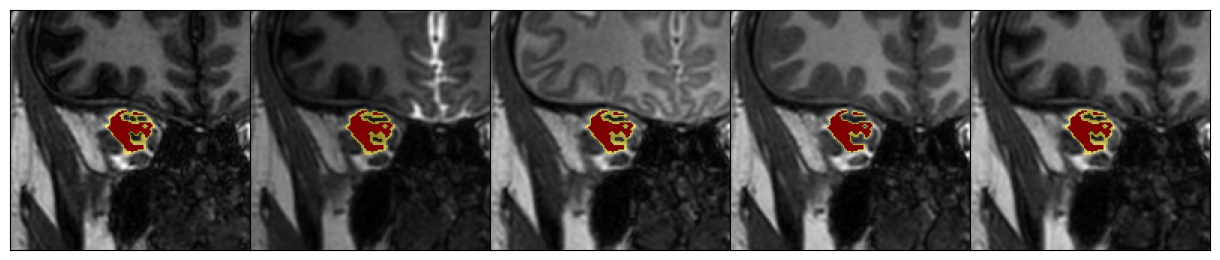

In [30]:
grid_config = {
    "fig_width": 12,
    "fig_top_margin": 0.0,
    "fig_bottom_margin": 0.0,
    "fig_left_margin": 0.0,
    "fig_right_margin": 0.0,
    "col_top_margin": 0.0,
    "col_bottom_margin": 0.0,
    "row_left_margin": 0.0,
    "row_right_margin": 0.0,
}


fig, axes = build_image_grid([[binary_slice[window]] * 5], grid_config)
axes = axes["body"][0]
s = slices[1]
for idx, vol in enumerate([mri.data for mri in mris]):
    image = slice_volume(vol, *s)
    mask = slice_volume(np.where(masks[idx], idx, np.nan), *s)
    roi_slice = slice_volume(np.where(roi, 1, np.nan), *s)
    ax = axes[idx]
    ax.imshow(image[window], cmap="gray")
    ax.imshow(mask[window], cmap="viridis_r", alpha=0.5)
    ax.imshow(roi_slice[window], cmap="jet_r", alpha=1.0)

plt.savefig("../figures/t1w-normalization-mask-temporal.pdf", bbox_inches="tight")
plt.show()

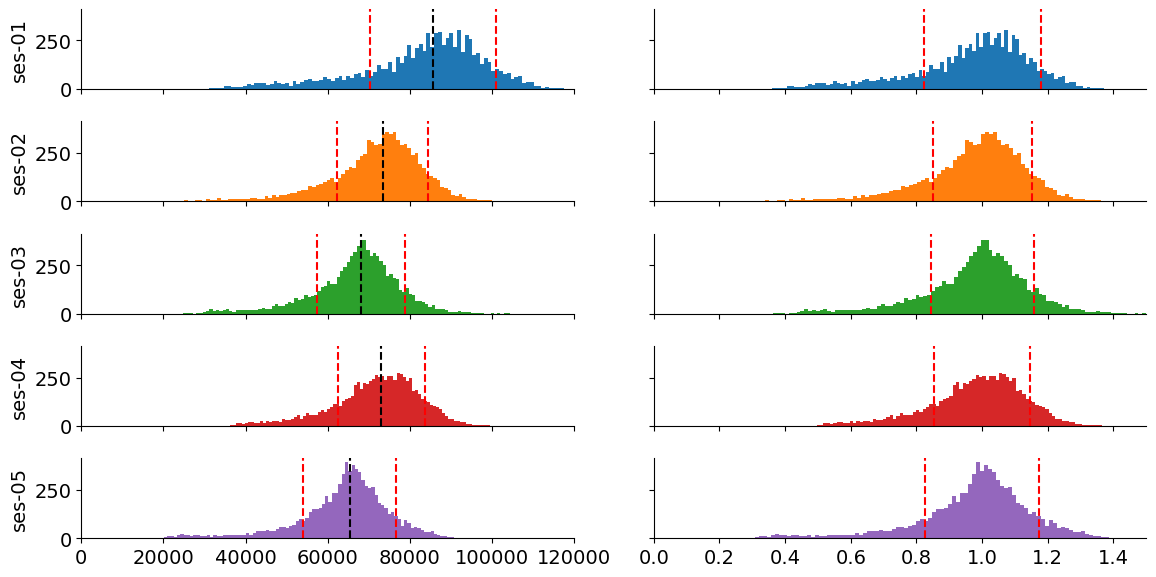

In [31]:
vols = np.array([mri.data for mri in mris])
normalized = vols / np.median(vols[:, roi], axis=1).reshape(vols.shape[0], 1, 1, 1)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fix, axes = plt.subplots(5, 2, figsize=(12, 6), sharex='col', sharey=True)
axes = axes.ravel(order="F")
for idx, vol in enumerate(vols, start=0):
    ax = axes[idx]
    ax.hist(vol[roi], bins=100, label=f"ses-{idx+1:02d}", color=colors[idx])
    ax.axvline(np.median(vol[roi]), ls="--", c="k")
    ax.axvline(np.median(vol[roi]) + vol[roi].std(), ls="--", c="r")
    ax.axvline(np.median(vol[roi]) - vol[roi].std(), ls="--", c="r")

    ax.set_ylabel(f"ses-{idx+1:02d}")
ax.set_xlim(0, 120000)


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for idx, vol in enumerate(normalized, start=0):
    ax = axes[5 + idx]
    ax.hist(vol[roi], bins=100, label=f"ses-{idx+1:02d}", color=colors[idx])
    ax.axvline(np.median(vol[roi]) + vol[roi].std(), ls="--", c="r")
    ax.axvline(np.median(vol[roi]) - vol[roi].std(), ls="--", c="r")
    ax.set_xlim(0, 1.5)

for ax in axes:
    ax.spines[["right", "top"]].set_visible(False)
plt.tight_layout()
# plt.savefig("../figures/T1w-normalization-distributions.pdf")
plt.show()

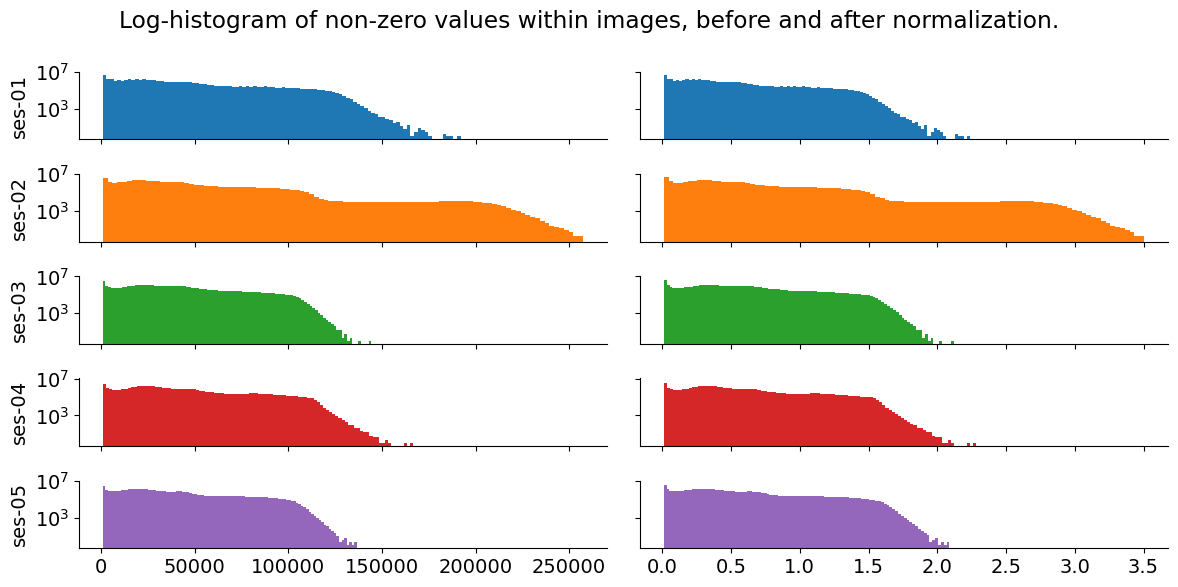

In [32]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fix, axes = plt.subplots(5, 2, figsize=(12, 6), sharex='col', sharey=True)
axes = axes.ravel(order="F")
for idx, vol in enumerate(vols, start=0):
    ax = axes[idx]
    ax.hist(vol[vol > 1000], bins=100, label=f"ses-{idx+1:02d}", color=colors[idx])
    ax.set_ylabel(f"ses-{idx+1:02d}")


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for idx, vol in enumerate(normalized, start=0):
    ax = axes[5 + idx]
    ax.hist(vol[vol > 0.01], bins=100, label=f"ses-{idx+1:02d}", color=colors[idx])
    ax.set_yscale("log")

for ax in axes:
    ax.spines[["right", "top"]].set_visible(False)
plt.suptitle("Log-histogram of non-zero values within images, before and after normalization.")
plt.tight_layout()
plt.show()

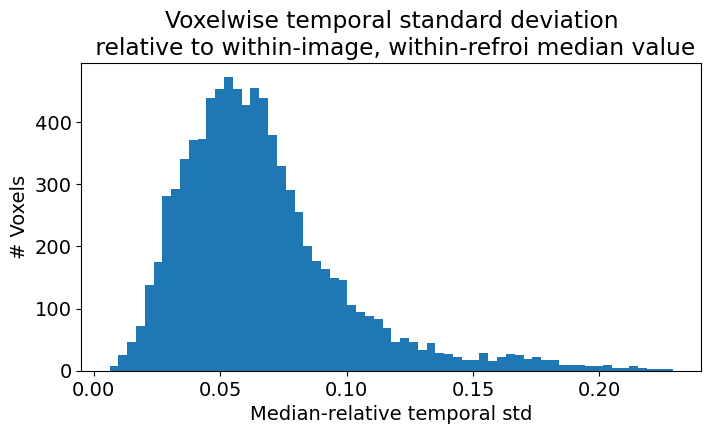

In [33]:
temporal_std = (vols[:, roi] / np.median(vols[:, roi], axis=1, keepdims=1)).std(axis=0)
plt.figure(figsize=(8, 4))
bins = plt.hist(temporal_std, bins=64)
plt.title("Voxelwise temporal standard deviation\n relative to within-image, within-refroi median value")
plt.ylabel("# Voxels")
plt.xlabel("Median-relative temporal std")
plt.show()

## Appendix
### Different thresholding algorithms
This plot shows the signal intensity distributions and the threshold created by different thresholding algorithms on the "focused" reference MRI-image. Take-away for this example is that Otsu, Isodata and Yen provide very similar thresholds.

We have used Yen as the thresholding algorihtm, with Otsu as fallback.

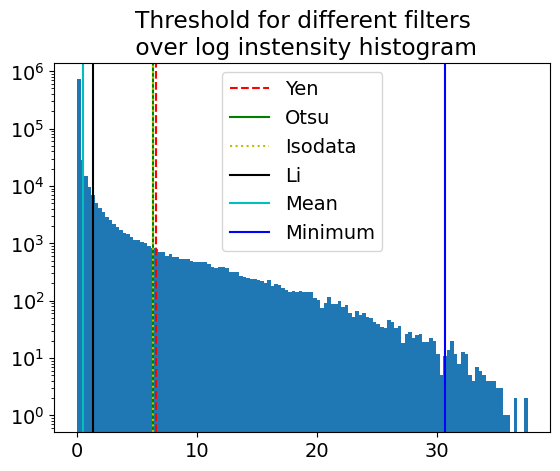

In [42]:
weights = orbital_weights_distribution(ref_mri, seg_mri, "left")
image = ref_mri.data * weights
mask = threshold_weighted_image(ref_mri.data, weights)

hist, bin_edges, _ = plt.hist(image[image > 1e-6], bins=128)
bins = (bin_edges[:-1] + bin_edges[1:]) / 2
yen_thresh = skimage.filters.threshold_yen(hist=(hist, bins))
otsu_thresh = skimage.filters.threshold_otsu(hist=(hist, bins))
iso_thresh = skimage.filters.threshold_isodata(hist=(hist, bins))
min_thresh = skimage.filters.threshold_minimum(hist=(hist, bins))
li_thresh = skimage.filters.threshold_li(image[image > 1e-6])
mean_thresh = skimage.filters.threshold_mean(image[image > 1e-6])

plt.axvline(yen_thresh, c="r", ls="--",label="Yen")
plt.axvline(otsu_thresh, c="g", label="Otsu")
plt.axvline(iso_thresh, c="y", label="Isodata", ls=":")
plt.axvline(li_thresh, c="k", label="Li")
plt.axvline(mean_thresh, c="c", label="Mean")
plt.axvline(min_thresh, c="b", label="Minimum")

plt.yscale("log")
plt.title("Threshold for different filters\n over log instensity histogram")
plt.legend()
plt.show()